In [1]:
import os
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from modules.lifter_2d_3d.dataset.simple_keypoint_dataset import SimpleKeypointDataset
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear
from modules.utils.visualization import (
    plot_samples
)
from IPython.display import display
from pathlib import Path
pl.seed_everything(1234)

# ------------
# dataset path
# ------------
dataset_root_path = Path('/root/data/processed/synthetic_cabin_ir/A_Pillar_Codriver')
keypoint_2d_path = dataset_root_path / 'keypoint_detection_results'
keypoint_3d_path = dataset_root_path / 'annotations'
# ------------
# model
# ------------
image_width = 1280
image_height = 1024
batch_size = 64
max_epoch = 200
val_check_period = 5
early_stopping_patience = 5
lit_model = LitSimpleBaselineLinear(exclude_ankle=True, exclude_hip=True)
# ------------
# saved model path
# ------------
saved_model_path = './saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/prediction/linear_model/'


train_dataset = SimpleKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    exclude_ankle=True,
    exclude_hip=True
)
val_dataset = SimpleKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_val.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_val.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    exclude_ankle=True,
    exclude_hip=True
)
test_dataset = SimpleKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_test.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_test.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    exclude_ankle=True,
    exclude_hip=True
)

print(
    'train_dataset', len(train_dataset),
    'val_dataset', len(val_dataset),
    'test_dataset', len(test_dataset)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=24)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, num_workers=24)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=24)

model_checkpoint = ModelCheckpoint(monitor='val_loss',mode='min', save_top_k=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience)


if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = pl.Trainer(
    # max_steps=10,
    max_epochs=max_epoch,
    callbacks=[model_checkpoint, early_stopping],
    accelerator=device,
    check_val_every_n_epoch=val_check_period,
    default_root_dir=saved_model_path,
    gradient_clip_val=1.0
)
trainer.fit(lit_model, train_loader, val_loader)

Global seed set to 1234
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/prediction/linear_model/lightning_logs


train_dataset 37499 val_dataset 6250 test_dataset 6251


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | BaselineModel | 4.3 M 
----------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.105    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

check #0
val MPJPE from: 128 samples : 4060.011863708496


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-h7gc_8z0'


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

check #1
training loss from 2925 batches: 314.13409610079907
val MPJPE from: 6208 samples : 66.44697487354279


Validation: 0it [00:00, ?it/s]

check #2
training loss from 2925 batches: 81.27195040767009
val MPJPE from: 6208 samples : 43.831028044223785


Validation: 0it [00:00, ?it/s]

check #3
training loss from 2925 batches: 67.71235816371747
val MPJPE from: 6208 samples : 40.517374873161316


Validation: 0it [00:00, ?it/s]

check #4
training loss from 2925 batches: 62.41780182362622
val MPJPE from: 6208 samples : 40.90750217437744


Validation: 0it [00:00, ?it/s]

check #5
training loss from 2925 batches: 58.928358222429566
val MPJPE from: 6208 samples : 38.017261773347855


Validation: 0it [00:00, ?it/s]

check #6
training loss from 2925 batches: 56.7404765705777
val MPJPE from: 6208 samples : 38.377758115530014


Validation: 0it [00:00, ?it/s]

check #7
training loss from 2925 batches: 54.40114759609231
val MPJPE from: 6208 samples : 36.95473074913025


Validation: 0it [00:00, ?it/s]

check #8
training loss from 2925 batches: 52.96515759367209
val MPJPE from: 6208 samples : 37.222638726234436


Validation: 0it [00:00, ?it/s]

check #9
training loss from 2925 batches: 51.790922582149506
val MPJPE from: 6208 samples : 35.978712141513824


Validation: 0it [00:00, ?it/s]

check #10
training loss from 2925 batches: 50.70438422453709
val MPJPE from: 6208 samples : 34.77229177951813


Validation: 0it [00:00, ?it/s]

check #11
training loss from 2925 batches: 49.85574061289812
val MPJPE from: 6208 samples : 35.15169024467468


Validation: 0it [00:00, ?it/s]

check #12
training loss from 2925 batches: 49.21045241829677
val MPJPE from: 6208 samples : 35.57996824383736


Validation: 0it [00:00, ?it/s]

check #13
training loss from 2925 batches: 48.56195956595943
val MPJPE from: 6208 samples : 34.47902947664261


Validation: 0it [00:00, ?it/s]

check #14
training loss from 2925 batches: 48.07855745283966
val MPJPE from: 6208 samples : 34.771256148815155


Validation: 0it [00:00, ?it/s]

check #15
training loss from 2925 batches: 47.658584161191925
val MPJPE from: 6208 samples : 34.59235653281212


Validation: 0it [00:00, ?it/s]

check #16
training loss from 2925 batches: 47.326024973239655
val MPJPE from: 6208 samples : 34.452758729457855


Validation: 0it [00:00, ?it/s]

check #17
training loss from 2925 batches: 47.12204026615518
val MPJPE from: 6208 samples : 34.212540835142136


Validation: 0it [00:00, ?it/s]

check #18
training loss from 2925 batches: 46.84729359470881
val MPJPE from: 6208 samples : 34.317199140787125


Validation: 0it [00:00, ?it/s]

check #19
training loss from 2925 batches: 46.641576514284836
val MPJPE from: 6208 samples : 34.15295481681824


Validation: 0it [00:00, ?it/s]

check #20
training loss from 2925 batches: 46.577424222332795
val MPJPE from: 6208 samples : 34.54241156578064


Validation: 0it [00:00, ?it/s]

check #21
training loss from 2925 batches: 46.43396802692332
val MPJPE from: 6208 samples : 34.417524933815


Validation: 0it [00:00, ?it/s]

check #22
training loss from 2925 batches: 46.316350494694504
val MPJPE from: 6208 samples : 33.95784646272659


Validation: 0it [00:00, ?it/s]

check #23
training loss from 2925 batches: 46.09921671513818
val MPJPE from: 6208 samples : 34.55303981900215


Validation: 0it [00:00, ?it/s]

check #24
training loss from 2925 batches: 46.16929894329136
val MPJPE from: 6208 samples : 34.19467434287071


Validation: 0it [00:00, ?it/s]

check #25
training loss from 2925 batches: 46.094795760945374
val MPJPE from: 6208 samples : 34.159719944000244


Validation: 0it [00:00, ?it/s]

check #26
training loss from 2925 batches: 46.106135603199654
val MPJPE from: 6208 samples : 34.05671939253807


Validation: 0it [00:00, ?it/s]

check #27
training loss from 2925 batches: 45.88579015217276
val MPJPE from: 6208 samples : 34.07639265060425


In [2]:
with open(f'{saved_model_path}/best_model_path.txt', 'w') as f:
    f.writelines(model_checkpoint.best_model_path)

In [3]:
best_checkpoint_path = model_checkpoint.best_model_path
trainer.test(ckpt_path=best_checkpoint_path, dataloaders=test_loader)

Restoring states from the checkpoint path at saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/prediction/linear_model/lightning_logs/version_0/checkpoints/epoch=109-step=64350.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/prediction/linear_model/lightning_logs/version_0/checkpoints/epoch=109-step=64350.ckpt


Testing: 0it [00:00, ?it/s]

MPJPE: 36.48674597321543
PJPE
                     PJPE
nose            30.297487
left_eye        29.503254
right_eye       29.433992
left_ear        28.591261
right_ear       27.441324
left_shoulder   25.835224
right_shoulder  29.200397
left_elbow      89.477179
right_elbow     55.640124
left_wrist      47.888141
right_wrist     39.411571
left_hip        27.230872
right_hip       14.376873
activities_mpjpe:
{}
test mpjpe: 36.48674597321543


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           mpjpe           │     36.48674597321543     │
└───────────────────────────┴───────────────────────────┘

[{'mpjpe': 36.48674597321543}]

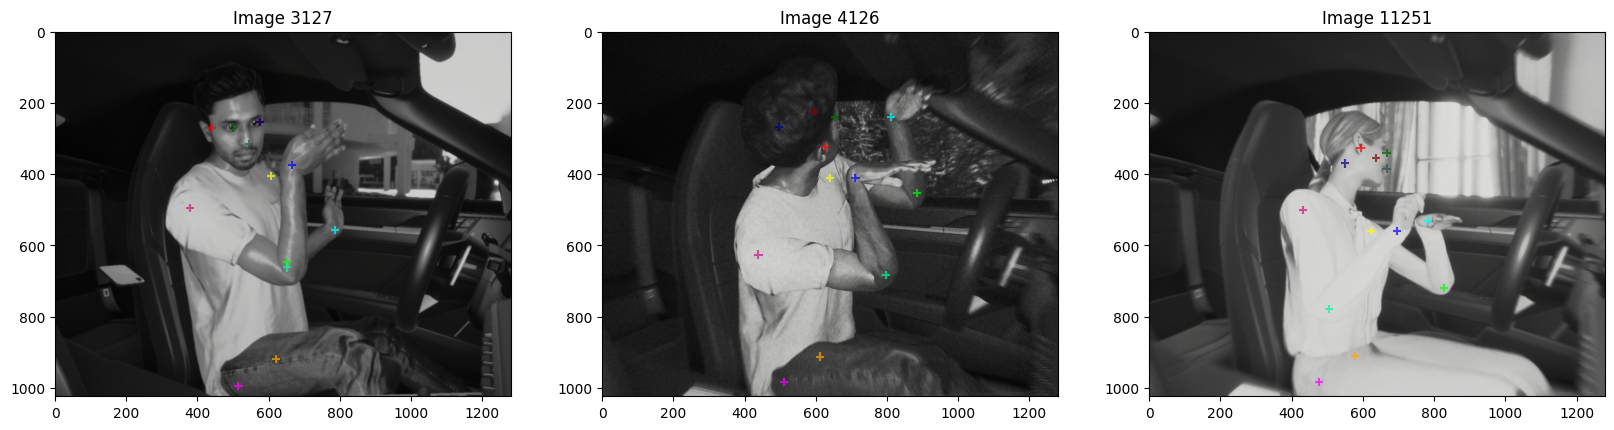

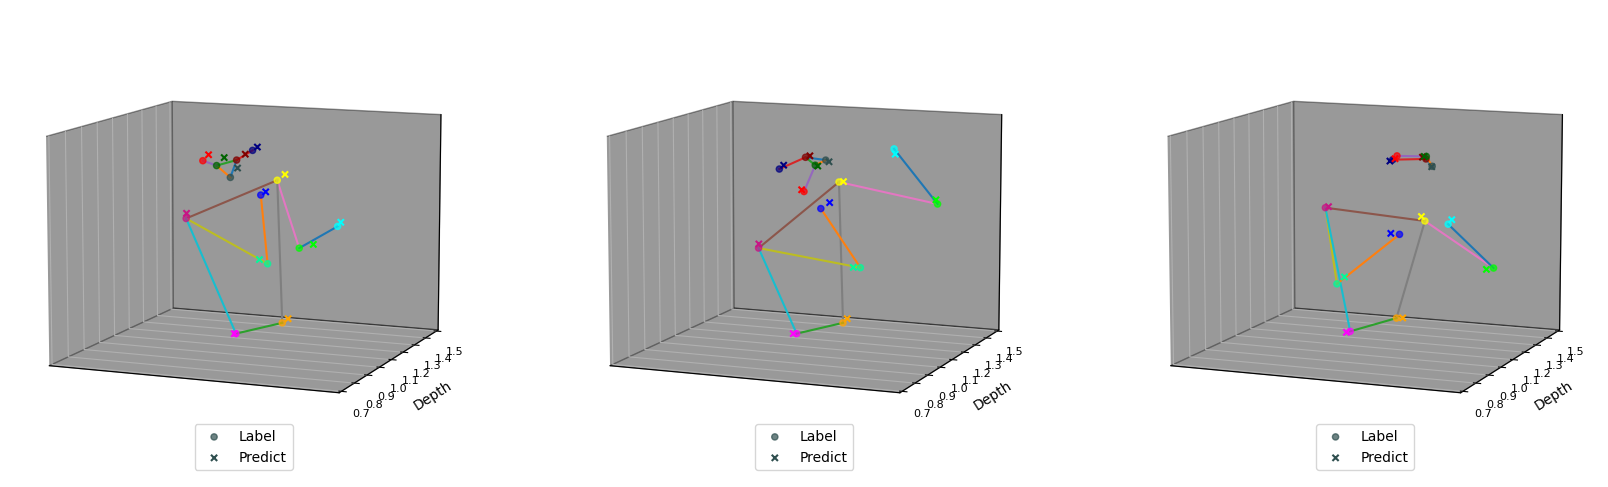

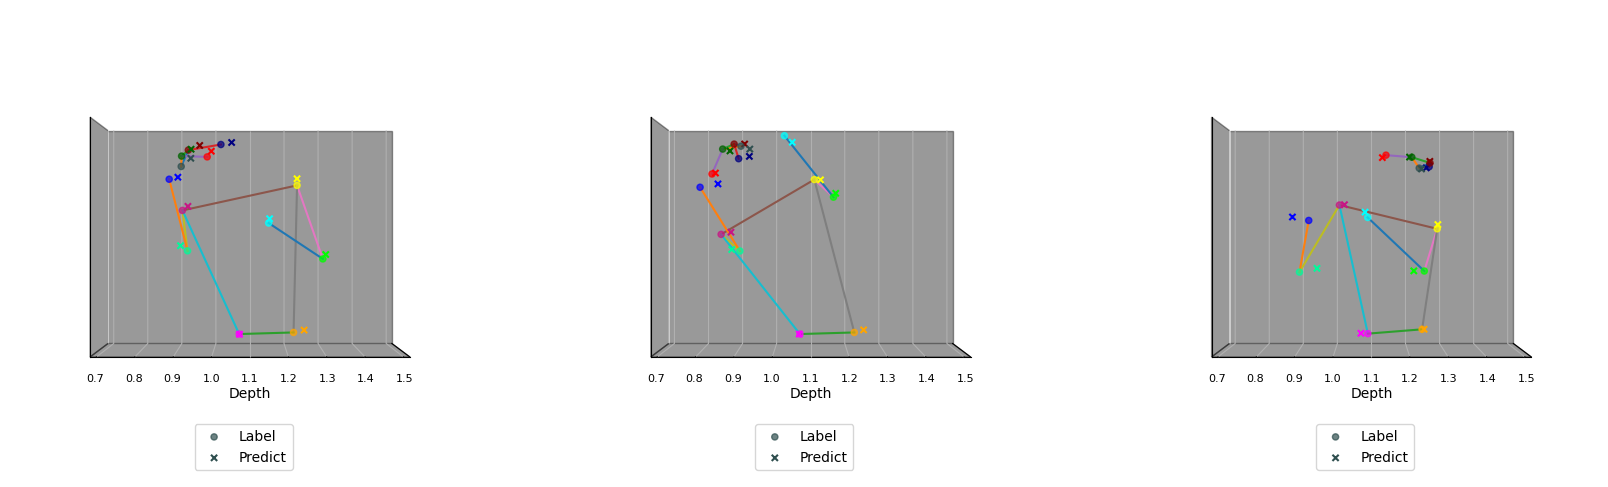

In [13]:
plot_samples(
    dataset_root_path,
    trainer.model,
    val_loader,
    img_figsize=(20, 10),
    img_width=image_width,
    img_height=image_height,
    plot_figsize=(20.5, 10),
    sample_idices=[1, 1000, 5000]
)